In [1]:
# work in progress

In [2]:
# TODO

# NOTE could it be a confound if smaller pain reductions are not detected?
# or if big pain reductions are quite rare (3 per one trial over 4 min, as of now)
# -> should we only do "big" pain reductions?

In [3]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')
    %load_ext autoreload
    %autoreload 2

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, Slider, Checkbox, Legend, LegendItem, Div
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from src.experiments.stimuli_function import StimuliFunction, stimuli_extra


In [5]:
minimal_desired_duration = 200 # in seconds
periods = [67*2, 20] # [0] is the baseline and [1] the modulation; in seconds
frequencies = 1./np.array(periods)
amplitudes = [1, 1.5] # temp range is 2 * sum(amplitudes): max @ VAS 70, min @ VAS 0
sample_rate = 10
seed = None #823 # use None for random seed
baseline_temp = 39.2 # @ VAS 35

In [6]:
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "12m0h5gjq9dg22vs1mbdqjhqj2tqndvlf05prafmri9ph52dvc4v"

output_notebook()

def modify_doc(doc):
    """Modifies the document with the given stimuli function and plots."""
    def create_stimuli():
        """Creates and returns a stimuli function."""
        return StimuliFunction(
            minimal_desired_duration,
            frequencies,
            amplitudes,
            sample_rate=sample_rate,
            random_periods=False)

    def create_sources(stimuli):
        """Creates and returns sources for wave, baseline, and modulation."""
        x = np.arange(0, stimuli.duration, 1 / stimuli.sample_rate)
        return [ColumnDataSource(data=dict(x=x, y=attr)) for attr in [stimuli.wave, stimuli.baseline, stimuli.modulation]]

    def create_plot():
        """Creates and returns a plot with wave, baseline, and modulation lines."""
        plot = figure(height=400, width=800)
        colors = ["navy", "grey", "grey"]
        line_dashes = ["solid", 'dotted', 'dashed']
        lines = [plot.line('x', 'y', source=source, line_width=2 if idx else 3, line_alpha=0.6, color=color, line_dash=line_dash) 
                  for idx, (source, color, line_dash) in enumerate(zip(sources, colors, line_dashes))]
        lines[1].visible = lines[2].visible = False
        plot.xaxis.axis_label = 'Time (s)'
        plot.yaxis.axis_label = 'Temperature - Baseline (°C)'

        # Add legend
        legend_labels = ['stimuli', 'baseline', 'modulation']
        legend_items = [LegendItem(label=label, renderers=[line]) for label, line in zip(legend_labels, lines)]
        legend = Legend(items=legend_items, location="center")
        plot.add_layout(legend, 'below')
        plot.legend.orientation = "horizontal"
        return plot, lines

    # Set up data
    stimuli = create_stimuli()
    sources = create_sources(stimuli)
    plot, lines = create_plot()

    def create_sliders():
        """Creates and returns sliders for periods and amplitudes."""
        sliders = [
            Slider(start=start, end=end, value=value, step=step, title=title) 
            for start, end, value, step, title in [
                (40, 150, 90, 1, "Period Baseline"), 
                (10, 30, 20, 1, "Period Modulation"),
                (0, 3, 1, 0.25, "Amplitude Baseline"), 
                (0, 3, 1.5, 0.25, "Amplitude Modulation")
                ]]
        return sliders

    def create_checkboxes():
        """Creates and returns checkboxes for random periods, plot baseline, and plot modulation."""
        return [Checkbox(label=label, active=False) for label in [
            "Plot Baseline", "Plot Modulation", "Random periods"]]

    def callback(attr, old, new):
        """Updates the stimuli, sources, and lines based on the slider and checkbox values."""
        amplitudes = np.array([sliders[2].value, sliders[3].value])
        periods = [sliders[0].value, sliders[1].value]
        frequencies = 1./np.array(periods)
        stimuli = StimuliFunction(
            minimal_desired_duration,
            frequencies,
            amplitudes,
            sample_rate=sample_rate,
            random_periods=checkboxes[2].active)
        x = np.arange(0, stimuli.duration, 1 / stimuli.sample_rate)
        y = stimuli.wave
        sources[0].data = dict(x=x, y=y)
        lines[1].visible = checkboxes[0].active
        if lines[1].visible:
            sources[1].data = dict(x=x, y=stimuli.baseline)
        lines[2].visible = checkboxes[1].active
        if lines[2].visible:
            sources[2].data = dict(x=x, y=stimuli.modulation)

    # Set up widgets
    sliders = create_sliders()
    checkboxes = create_checkboxes()
    for slider in sliders:
        slider.on_change('value', callback)
    for checkbox in checkboxes:
        checkbox.on_change('active', callback)

    # Set up layouts and add to document
    periods_title = Div(text=f"<h2>Periods{'&nbsp;'*42}</h2>")
    amplitudes_title = Div(text="<h2>Amplitudes</h2>")
    titles = row(periods_title, amplitudes_title)
    baseline_slider_rows = row(sliders[0], sliders[2])
    modulation_slider_row = row(sliders[1], sliders[3]) 
    checkbox_row = row(*checkboxes)
    layout = column(titles, baseline_slider_rows, modulation_slider_row, checkbox_row, plot)
    doc.add_root(layout)

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)


Loading BokehJS ...

In [7]:
import numpy as np
minimal_desired_duration = 200 # in seconds
periods = [67, 20] # [0] is the baseline and [1] the modulation; in seconds
frequencies = 1./np.array(periods)
amplitudes = [1, 1.5] # temp range is 2 * sum(amplitudes): max @ VAS 70, min @ VAS 0
sample_rate = 60
seed = None# 463 # use None for random seed
baseline_temp = 39.2 # @ VAS 35

stimuli = StimuliFunction(
    minimal_desired_duration=minimal_desired_duration,
    frequencies=frequencies,
    amplitudes=amplitudes,
    sample_rate=sample_rate,
    random_periods=True,
    defined_decreases=True,
    seed=seed
).add_baseline_temp(
    baseline_temp=baseline_temp
).add_plateaus(
    plateau_duration=20, 
    n_plateaus=3, 
    add_at_start=False, 
    add_at_end=False
).generalize_big_decreases(
    temp_criteria=3,
    duration=30
)

print(f"Seed: {stimuli.seed}")
print(stimuli.check_decreases(3))
_ = stimuli_extra(stimuli.wave, stimuli.wave_dot, stimuli.sample_rate, s_RoC=0.2, display_stats=False)

Seed: 251
({'big': array([0, 3, 4], dtype=int64), 'small': array([1, 2], dtype=int64)}, array([3.03385539, 2.90568735, 2.68821658, 3.04515019, 4.95834008]))


In [22]:
stimuli.check_decreases(3)[0]["big"].size
stimuli.wave[stimuli.loc_maxima[stimuli.check_decreases(3)[0]["big"]]]

array([40.42049271, 41.63468042])

In [9]:
temp_range = 3
baseline_temp = 39.2

minimal_desired_duration = 200 # in seconds
periods = [67, 20] # [0] is the baseline and [1] the modulation; in seconds
frequencies = 1./np.array(periods)
# calculate amplitudes based on VAS 70 - VAS 0
temp_range = temp_range # VAS 70 - VAS 0
amplitudes = [2/3*temp_range/2, 1*temp_range/2]

sample_rate = 60
random_periods = True
amplitudes

[1.0, 1.5]

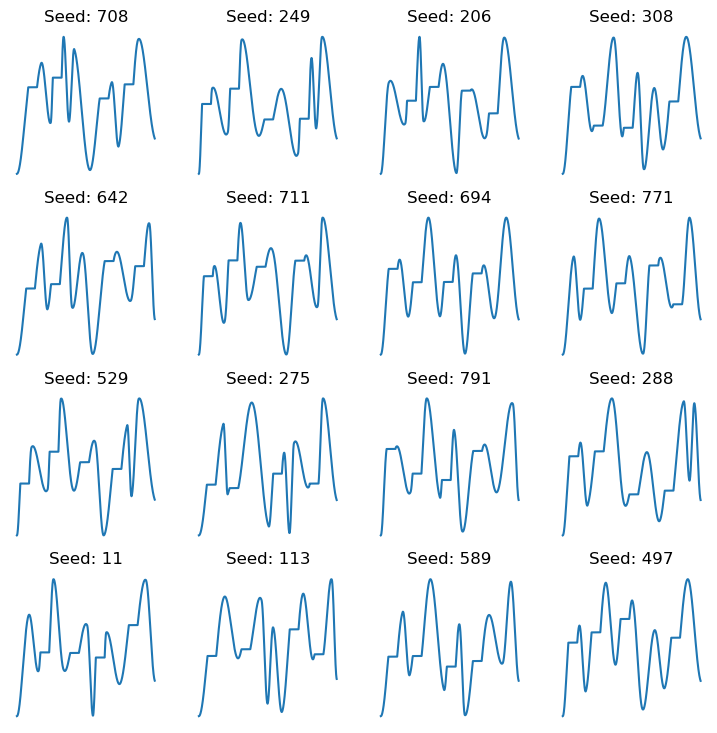

In [23]:
# Plot stimuli
import matplotlib.pyplot as plt

rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 9), dpi=100)
random_seeds = np.random.randint(0, 1000, rows*cols)

for ax, random_seed in zip(axes.flat, random_seeds):
    stimuli = StimuliFunction(
        minimal_desired_duration,
        frequencies,
        amplitudes,
        sample_rate,
        random_periods=True,
        seed=int(random_seed)
    ).add_plateaus(
        plateau_duration=20, 
        n_plateaus=4, 
        add_at_start=False, 
        add_at_end=False
    ).wave
    ax.plot(stimuli)
    ax.set_title(f"Seed: {random_seed}")
    ax.axis(False)

In [13]:
import numpy as np
minimal_desired_duration = 200 # in seconds
periods = [135, 23] # [0] is the baseline and [1] the modulation; in seconds
frequencies = 1./np.array(periods)
amplitudes = [1, 1.5] # temp range is 2 * sum(amplitudes): max @ VAS 70, min @ VAS 0
sample_rate = 60
seed = 463 # use None for random seed
baseline_temp = 39.2 # @ VAS 35

stimuli = StimuliFunction(
    minimal_desired_duration=minimal_desired_duration,
    frequencies=frequencies,
    amplitudes=amplitudes,
    sample_rate=10,
    random_periods=True,
    seed=seed
).add_baseline_temp(
    baseline_temp=baseline_temp
).add_plateaus(
    plateau_duration=20, 
    n_plateaus=4, 
    add_at_start="random", 
    add_at_end=False)
print(f"Seed: {stimuli.seed}")
_ = stimuli_extra(stimuli.wave, stimuli.wave_dot, stimuli.sample_rate, s_RoC=0.2, display_stats=False)

stimuli.loc_maxima/stimuli.sample_rate, stimuli.loc_minima/stimuli.sample_rate
stimuli.wave[stimuli.loc_maxima], stimuli.wave[stimuli.loc_minima]

Seed: 463


(array([40.00231549, 41.18218819, 40.42049271, 39.88450838, 41.63468042]),
 array([37.46643382, 38.58807814, 36.93893788, 37.50166536, 37.9912588 ]))

In [14]:
# ... [previous code to find idx_big_decreases_start and idx_big_decreases_end]

# Generate the new wave section
x = np.linspace(0, np.pi, dur)
y = np.cos(x) * temp_diffs[0]/2 + stimuli.wave[idx_big_decreases_start] - temp_diffs[0]/2

# Replace the old section with the new one
wave_new = stimuli.wave.copy()  # Create a copy of the original wave
wave_new[idx_big_decreases_start:idx_big_decreases_start + dur] = y  # Replace the section with the new wave

# Plotting
plt.plot(stimuli.wave, label='Original Wave')
plt.plot(range(idx_big_decreases_start, idx_big_decreases_start + dur), y, label='Inserted Wave', linestyle='dashed')
plt.legend()
plt.show()

NameError: name 'dur' is not defined

In [ ]:
loc_maxima_temps

array([40.00231549, 41.18218819, 40.42049271, 39.88450838, 41.63468042])

In [ ]:
idx_big_decreases
np.array([stimuli.loc_maxima[i] for i in idx_big_decreases])
idx_big_decreases


array([2, 4], dtype=int64)

1457

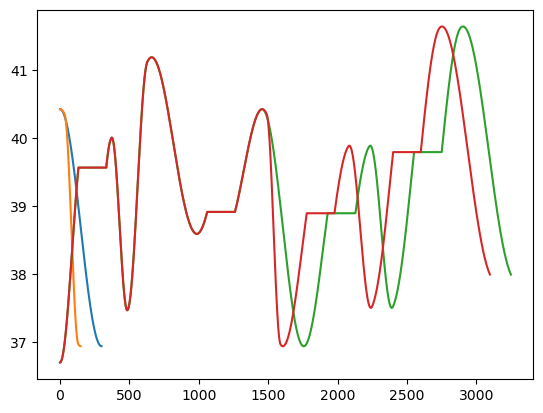

In [ ]:
# Identify number of big decreases in the wave
loc_maxima_temps = stimuli.wave[stimuli.loc_maxima]
loc_minima_temps = stimuli.wave[stimuli.loc_minima]
temp_diffs = loc_maxima_temps - loc_minima_temps

temp_criteria = 3
idx_big_decreases = np.where(((loc_maxima_temps - loc_minima_temps) > temp_criteria) == 1)[0]

# Make big decreases iterativly uniform
# Start with one big decrease
idx_start = np.array([stimuli.loc_maxima[i] for i in idx_big_decreases])[0]
idx_end = np.array([stimuli.loc_minima[i] for i in idx_big_decreases])[0]

idx_start, idx_end

# from these two points we want to span a new wave that is exactly dur s long
dur_in_s = 30 * stimuli.sample_rate

x = np.linspace(0, np.pi, dur_in_s)
y = np.cos(x) * temp_diffs[2]/2 + stimuli.wave[idx_start] - temp_diffs[2]/2 # Compute the corresponding y values

# Create a new list to hold the modified wave
wave_new = []

# Iterate over the original wave and replace the segment
for idx, i in enumerate(stimuli.wave):
    if idx < idx_start or idx >= idx_end:
        # Keep the original wave values outside the segment to replace
        wave_new.append(i)
    elif idx == idx_start:
        # Insert the new wave segment and skip the old segment
        wave_new.extend(y)

# Convert the modified wave list to a numpy array
wave_new = np.array(wave_new)


plt.plot(y)
plt.plot(stimuli.wave[idx_start:idx_end])
plt.plot(wave_new)
plt.plot(stimuli.wave)
idx_start

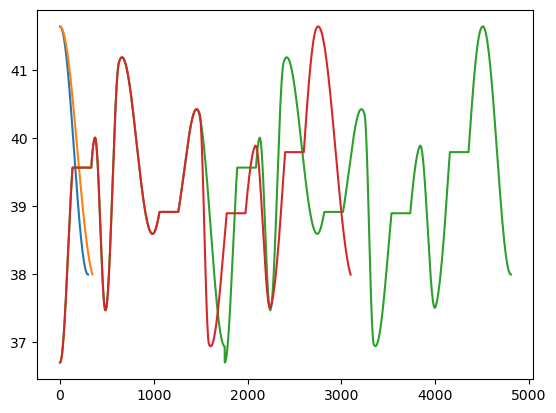

In [ ]:

# Create a new list to hold the modified wave
wave_new = []

loc_maxima_temps = stimuli.wave[stimuli.loc_maxima]
loc_minima_temps = stimuli.wave[stimuli.loc_minima]
temp_diffs = loc_maxima_temps - loc_minima_temps

temp_criteria = 3
idx_big_decreases = np.where(((loc_maxima_temps - loc_minima_temps) > temp_criteria) == 1)[0]

for idx, j in enumerate(idx_big_decreases):

    # Identify number of big decreases in the wave
    loc_maxima_temps = stimuli.wave[stimuli.loc_maxima]
    loc_minima_temps = stimuli.wave[stimuli.loc_minima]
    temp_diffs = loc_maxima_temps - loc_minima_temps

    temp_criteria = 3
    idx_big_decreases = np.where(((loc_maxima_temps - loc_minima_temps) > temp_criteria) == 1)[0]

    # Make big decreases iterativly uniform
    # Start with one big decrease
    idx_start = np.array([stimuli.loc_maxima[i] for i in idx_big_decreases])[idx]
    idx_end = np.array([stimuli.loc_minima[i] for i in idx_big_decreases])[idx]

    # from these two points we want to span a new wave that is exactly dur s long
    dur_in_s = 30 * stimuli.sample_rate

    x = np.linspace(0, np.pi, dur_in_s)
    y = np.cos(x) * temp_diffs[j]/2 + stimuli.wave[idx_start] - temp_diffs[j]/2 # Compute the corresponding y values

    # Iterate over the original wave and replace the segment
    for idx, i in enumerate(stimuli.wave):
        if idx < idx_start or idx >= idx_end:
            # Keep the original wave values outside the segment to replace
            wave_new.append(i)
        elif idx == idx_start:
            # Insert the new wave segment and skip the old segment
            wave_new.extend(y)
            break

# Convert the modified wave list to a numpy array
wave_new = np.array(wave_new)

plt.plot(y)
plt.plot(stimuli.wave[idx_start:idx_end])
plt.plot(wave_new)
plt.plot(stimuli.wave)

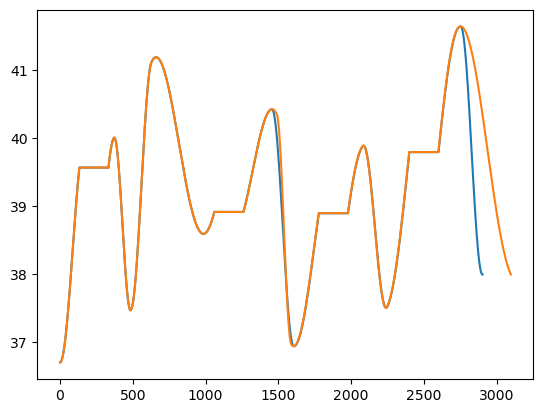

In [ ]:
# def generalize_big_decreases(self, temp_criteria=3, dur_in_s=30):


# Create a new list to hold the modified wave
wave_new = []

loc_maxima_temps = stimuli.wave[stimuli.loc_maxima]
loc_minima_temps = stimuli.wave[stimuli.loc_minima]
temp_diffs = loc_maxima_temps - loc_minima_temps

temp_criteria = 3
idx_big_decreases = np.where(((loc_maxima_temps - loc_minima_temps) > temp_criteria) == 1)[0]

# Initialize the starting index for the iteration over the original wave
idx_original = 0

for j in idx_big_decreases:
    idx_start = stimuli.loc_maxima[j]
    idx_end = stimuli.loc_minima[j]

    # Append the original wave values before the segment to replace
    wave_new.extend(stimuli.wave[idx_original:idx_start])

    # from these two points we want to span a new wave that is exactly dur s long
    dur_in_s = 15* stimuli.sample_rate
    x = np.linspace(0, np.pi, dur_in_s)
    y = np.cos(x) * temp_diffs[j]/2 + stimuli.wave[idx_start] - temp_diffs[j]/2  # Compute the corresponding y values

    # Insert the new wave segment
    wave_new.extend(y)

    # Update the starting index for the next iteration
    idx_original = idx_end

# Append the remaining original wave values after the last segment
wave_new.extend(stimuli.wave[idx_original:])

# Convert the modified wave list to a numpy array
wave_new = np.array(wave_new)

plt.plot(wave_new)
plt.plot(stimuli.wave)

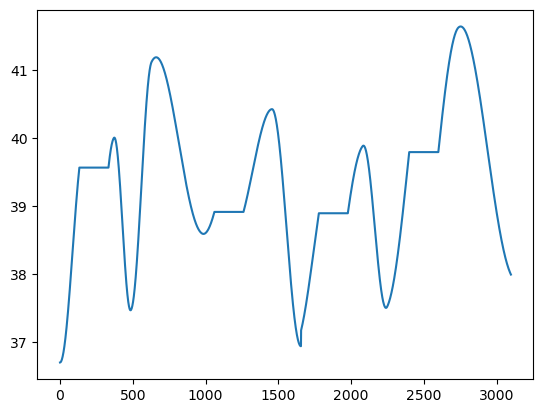

In [ ]:
# Replace the old section with the new one
wave_new = stimuli.wave.copy()  # Create a copy of the original wave
wave_new[idx_big_decreases_start:idx_big_decreases_start + dur] = y  # Replace the section with the new wave

plt.plot(wave_new)

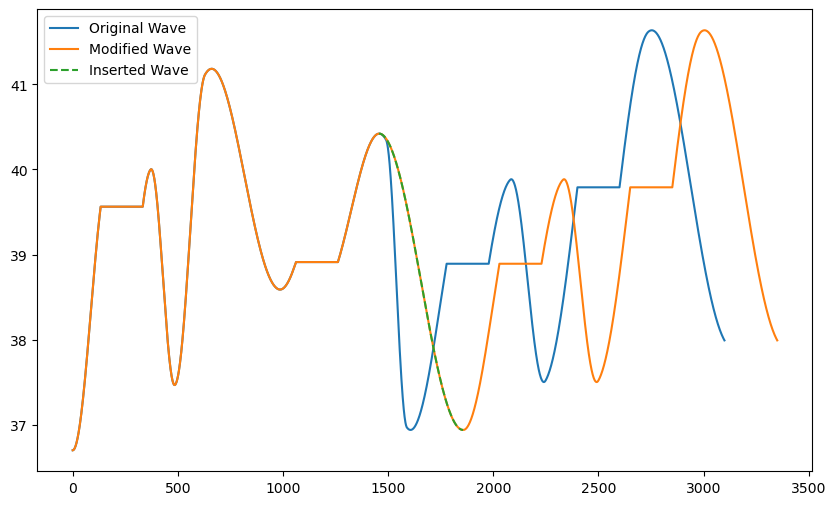

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


dur = 40 * stimuli.sample_rate

x = np.linspace(0, np.pi, dur)
y = np.cos(x) * temp_diffs[2]/2 + stimuli.wave[idx_big_decreases_start] - temp_diffs[2]/2 # Compute the corresponding y values


# Create a new list to hold the modified wave
wave_new = []

# Iterate over the original wave and replace the segment
for idx, i in enumerate(stimuli.wave):
    if idx < idx_big_decreases_start or idx >= idx_big_decreases_end:
        # Keep the original wave values outside the segment to replace
        wave_new.append(i)
    elif idx == idx_big_decreases_start:
        # Insert the new wave segment and skip the old segment
        wave_new.extend(y)

# Convert the modified wave list to a numpy array
wave_new = np.array(wave_new)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(stimuli.wave, label='Original Wave')
plt.plot(wave_new, label='Modified Wave')
plt.plot(range(idx_big_decreases_start, idx_big_decreases_start + len(y)), y, label='Inserted Wave', linestyle='dashed')
plt.legend()
plt.show()



In [ ]:
import plotly.graph_objects as go
import numpy as np

# Define the x values ranging from 0 to π
x = np.linspace(0, np.pi, 300) # 1000 points between 0 and π
y = np.cos(x) # Compute the corresponding y values

# Create the trace
trace = go.Scatter(x=x, y=y, mode='lines', name='Sine Wave')

# Create the layout
layout = go.Layout(title='1/4 Period of Sine Wave',
                   xaxis=dict(title='Angle (radians)'),
                   yaxis=dict(title='Amplitude'))

# Create the figure and plot it
fig = go.Figure(data=[trace], layout=layout)
fig.show()


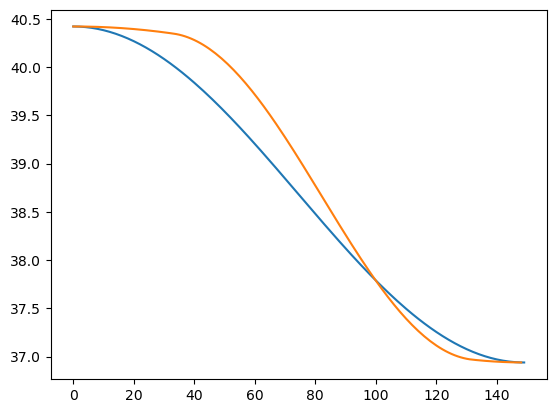

In [ ]:
# Identify number of big decreases in the wave
loc_maxima_temps = stimuli.wave[stimuli.loc_maxima]
loc_minima_temps = stimuli.wave[stimuli.loc_minima]
temp_diffs = loc_maxima_temps - loc_minima_temps

temp_criteria = 3
idx_big_decreases = np.where(((loc_maxima_temps - loc_minima_temps) > temp_criteria) == 1)[0]


# Make big decreases iterativly uniform
# Start with one big decrease
idx_big_decreases_start = np.array([stimuli.loc_maxima[i] for i in idx_big_decreases])[0]
idx_big_decreases_end = np.array([stimuli.loc_minima[i] for i in idx_big_decreases])[0]

idx_big_decreases_start, idx_big_decreases_end

# from these two points we want to span a new wave that is exactly 5 s long
dur = 15 * stimuli.sample_rate
x = np.linspace(0, np.pi, dur)
y = np.cos(x) * 3.4815548359062305/2 + stimuli.wave[idx_big_decreases_start] - 3.4815548359062305/2 # Compute the corresponding y values

wave_new = []
for idx, i in enumerate(stimuli.wave):
    wave_new.append(i)
    if idx == idx_big_decreases_start:
        wave_new.extend(y)
        
wave_new = np.array(wave_new)

plt.plot(y)
plt.plot(stimuli.wave[idx_big_decreases_start:idx_big_decreases_end])
# plt.plot(wave_new)